# Performance of Nasal-Swab Testing for SARS-CoV-2 by Collection Timing, Procedure, and Transport Method

Cody Callahan,$^{a}$ Rose A. Lee,$^{b,c,d}$ Ghee Rye Lee,$^{e}$ Kate Zulauf,$^{b,d}$ James E. Kirby,$^{b,d}$ and Ramy Arnaout$^{b,d,f,\#}$

$^{a}$Department of Radiology, Beth Israel Deaconess Medical Center, Boston, MA, USA 02215; $^{b}$Department of Pathology, Beth Israel Deaconess Medical Center, Boston, MA, USA; $^{c}$Division of Infectious Diseases, Department of Medicine, Beth Israel Deaconess Medical Center, Boston, MA, USA; $^{d}$Harvard Medical School, Boston, MA, USA; $^{e}$Department of Surgery, Beth Israel Deaconess Medical Center, Boston, MA, USA 02215; $^{f}$Division of Clinical Informatics, Department of Medicine, Beth Israel Deaconess Medical Center, Boston, MA USA 02215 

$^{\#}$To whom correspondence should be addressed at

Ramy Arnaout, MD, DPhil
Beth Israel Deaconess Medical Center 
330 Brookline Avenue—YA309 
Boston, MA 02215 
rarnaout@bidmc.harvard.edu
617-538-5681

## Supplementary File 2. callahan_nasal_vs_NP.ipynb: code to generate statistics and plots

In [13]:
from bisect import bisect
from collections import defaultdict
from ct2vl import ct2vl
from datetime import datetime
from getpass import getuser
from Levenshtein import distance
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from os.path import exists
from pickle import load
from scipy.stats import wilcoxon, gmean, mannwhitneyu as mwu
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics.cluster import contingency_matrix
from statsmodels.stats.multitest import fdrcorrection

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Note: you will have to set the locations of the data file and the folder where you want to save plots

In [14]:
# data_file and output folder for plots     <-- Change this as appropriate
if "User" in getuser():
    basedir = "/Users/Main_Directory/"
    indir = basedir + "Subdirectory/"
    plot_folder = basedir + "Plot_Output_Folder/"

data_file = "callahan_nasal_vs_NP_no_PHI.xlsx"
data_file = indir + data_file

In [11]:
# Load data
df = pd.read_excel(data_file, header=0)

# inspect it
with pd.option_context('display.max_rows', None):
    display(df)

,Study_ID,Test_Result,Ctrl_Result,Test_Ct,Ctrl_Ct,Transport,Procedure,Timing,Days
0,1,negative,positive,37.00,24.27,GITC,shallow,followup,29
1,2,negative,negative,37.00,37.00,GITC,shallow,initial,0
2,3,negative,negative,37.00,37.00,GITC,shallow,initial,0
3,4,positive,positive,27.35,23.49,GITC,shallow,followup,22
4,5,negative,negative,37.00,37.00,GITC,shallow,initial,0
5,6,positive,positive,6.77,5.09,GITC,shallow,followup,30
6,7,negative,positive,37.00,22.25,GITC,shallow,initial,0
7,8,negative,positive,37.00,24.71,GITC,shallow,followup,14
8,9,positive,positive,24.25,26.23,GITC,shallow,followup,20
9,10,negative,positive,37.00,26.68,GITC,shallow,followup,21


In [ ]:
def plot_contingency_table(contingency_table, color="#cccccc", reflect_across_y_equals_x=True, reflect_across_y_equals_negative_x=True, file="", save=False):
    """
    Note that contingency_matrix from sklearn.metrics.cluster returns values with (0,0) in the upper left 
    and (1, 1) in the lower right, but our desired table puts the +ses first, meaning (1,1) in the upper 
    left. Therefore we set the parameter "flip=True" by default.
    """
    # check that the shape is 2 x 2 (if not, something's missing, the contingency table will be a single column, and we can't plot it)
    if contingency_table.shape != (2,2):
        print("error: plot_contingency_table: shape not (2,2)")
        return
    # flip contingency table
    if reflect_across_y_equals_x:
        contingency_table = np.flip(contingency_table)
    # flip to make gold standard go across top vs. down left
    if reflect_across_y_equals_negative_x:
        contingency_table = contingency_table.T
    #
    # initialize figure
    plt.figure(figsize=(1.75, 1.75))
    # plot horizontal lines
    plt.plot((1, 3), (3, 3), linewidth=1, c="black")
    plt.plot((1, 3), (2, 2), linewidth=1, c="black")
    plt.plot((1, 4), (1, 1), linewidth=1, c="black")
    # plot vertical lines
    plt.plot((1, 1), (1, 3), linewidth=1, c="black")
    plt.plot((2, 2), (1, 3), linewidth=1, c="black")
    plt.plot((3, 3), (0, 3), linewidth=1, c="black")
    # get axes
    ax = plt.gca()    
    # add 2x2 table numbers
    plt.text(1.5, 2.5, str(contingency_table[0][0]), transform=ax.transData, ha="center", va="center")
    plt.text(2.5, 2.5, str(contingency_table[0][1]), transform=ax.transData, ha="center", va="center")
    plt.text(1.5, 1.5, str(contingency_table[1][0]), transform=ax.transData, ha="center", va="center")
    plt.text(2.5, 1.5, str(contingency_table[1][1]), transform=ax.transData, ha="center", va="center")
    # add totals
    plt.text(3.5, 2.5, str(np.sum(contingency_table, axis=1)[0]), transform=ax.transData, ha="center", va="center")
    plt.text(3.5, 1.5, str(np.sum(contingency_table, axis=1)[1]), transform=ax.transData, ha="center", va="center")
    plt.text(1.5, 0.5, str(np.sum(contingency_table, axis=0)[0]), transform=ax.transData, ha="center", va="center")
    plt.text(2.5, 0.5, str(np.sum(contingency_table, axis=0)[1]), transform=ax.transData, ha="center", va="center")
    plt.text(3.5, 0.5, str(np.sum(contingency_table)), transform=ax.transData, ha="center", va="center")
    #
    # add plusses and minuses
    plt.text(1.5, 3.5, "+", transform=ax.transData, ha="center", va="center", fontsize=16)
    plt.text(2.5, 3.5, "–", transform=ax.transData, ha="center", va="center", fontsize=16)
    plt.text(0.5, 2.5, "+", transform=ax.transData, ha="center", va="center", fontsize=16)
    plt.text(0.5, 1.5, "–", transform=ax.transData, ha="center", va="center", fontsize=16)
    #
    # shade off-diagonals
    ax.add_patch(Rectangle( (1, 1), 1, 1, color=color, zorder=-100 ))
    ax.add_patch(Rectangle( (2, 2), 1, 1, color=color, zorder=-100 ))
    #
    plt.xlim((0,4))
    plt.ylim((0,4))
    # remove border
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # remove ticks and labels
    plt.tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    #
    if save:
        plt.savefig(file, transparent=True)
    return

# Test it out
contingency_table = np.array(((9, 11), (1, 26)))
plot_contingency_table(contingency_table)

In [ ]:
# Our own version of contingency_matrix(), since scipy's version fails when a category is entirely missing from the data
def make_contingency_table(y1, y2, neg_val=37.):
    "y1 = gold standard"
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i, j in zip(y1, y2):
        if i == j:
            if i == 1: TP += 1
            else: TN += 1
        elif i == 1: FN += 1
        else: FP += 1
    contingency_table = np.array(  ((TN, FP), (FN, TP))  ) # note we adopt the convention of the falses first
    return contingency_table

# Test:
neg_val=37.
y1 = [1 if y < neg_val else 0 for y in list(df.Ctrl_Ct)] # y1 = control (NP)
y2 = [1 if y < neg_val else 0 for y in list(df.Test_Ct)] # y2 = test (nasal)
assert(np.all(contingency_matrix(y1, y2) == make_contingency_table(y1, y2)))

In [ ]:
def get_kappa(df, col1="Ctrl_Ct", col2="Test_Ct", neg_val=37.):
    y1 = [1 if y < neg_val else 0 for y in list(df[col1])] # y1 = control (NP)
    y2 = [1 if y < neg_val else 0 for y in list(df[col2])] # y2 = test (nasal)
    kappa = cohen_kappa_score(y1, y2)
    return kappa

def get_means(df, col1="Ctrl_Ct", col2="Test_Ct", neg_val=37., vl=False):
    # Note it's important that you get the means of only the positive concordants (true positives; TP); otherwise the relationship may appear to flip, as negatives in nasal will just have high values in ctrl
    try:
        y1, y2 = list(zip(*[(i, j) for _, (i, j) in df[[col1, col2]].iterrows() if i < neg_val and j < neg_val]))
    except ValueError: # must have been an empty list
        y1 = []
        y2 = []
    if vl:
        y1 = [ct2vl(i) for i in y1]
        y2 = [ct2vl(i) for i in y2]
        return gmean(y1), gmean(y2)
    else:
        return np.mean(y1), np.mean(y2)

In [ ]:
# function for making figure
figsize = (4,4.3)
                        
def make_figure(df, label, return_data=True, save=False, vl=False, size=20, alpha=0.7, fontsize=20):
    # plot figure
    plt.figure(figsize=figsize)
    x = df.Ctrl_Ct
    y = df.Test_Ct
    if vl:
        x = [ct2vl(i) for i in list(x)] # Ctrl_Ct
        y = [ct2vl(i) for i in list(y)] # Test_Ct
    plt.scatter(x, y, alpha=0.5, label=label, s=size, c="black") # note, control Ct on x-axis (~independent variable)
    #
    # 1:1 diagonal line
    if vl:
        plt.plot((1e-1, 1e10), (1e-1, 1e10), zorder=-1000, linewidth=0.5, c="black")
    else:
        plt.plot((1e-1, 1e10), (1e-1, 1e10), zorder=-1000, linewidth=0.5, c="black")            
    #
    # get kappa
    kappa = get_kappa(df, "Ctrl_Ct", "Test_Ct")
    #
    # plot cosmetics 
    label += "; κ=%.2f" % kappa
    plt.title(label)
    if vl:
        plt.xlabel("Viral load, NP swab", fontsize=fontsize)
        plt.ylabel("Viral load, nasal swab", fontsize=fontsize)
        plt.xlim((0.5, 1e10))
        plt.ylim((0.5, 1e10))
        plt.xscale('log')
        plt.yscale('log')
        plt.xticks([10**i for i in range(0, 10, 3)])
        plt.yticks([10**i for i in range(0, 10, 3)])
    else:
        plt.xlabel("Ct value, NP swab", fontsize=fontsize)
        plt.ylabel("Ct value, nasal swab", fontsize=fontsize)
        plt.xlim((0, 40))
        plt.ylim((0, 40))
        plt.xticks(range(0, 41, 10))
        plt.yticks(range(0, 41, 10))
    plt.grid(linewidth=0.5, alpha=0.5, zorder=-1000)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tight_layout()
    if save:
        f1, f2 = label.split(":")
        f1 = f1.strip()
        f2 = f2.strip()
        f1 = f1.replace(" ", "-")
        f2 = f2.replace("\n", " ")
        f2 = f2.replace("  ", " ")
        f2 = f2.replace(" ", "_")
        f2 = f2.replace(",", "")
        f2 = f2.replace(";", "")
        filebase = plot_folder + "/%s_%s" % (f1, f2)
        if vl:
            filebase += "_vl"
        plt.savefig(filebase + ".pdf", transparent=True)
    else: filebase = ""
    #
    # make 2x2 table
    y1 = [1 if y < neg_val else 0 for y in list(df.Ctrl_Ct)] # y1 = control (NP)
    y2 = [1 if y < neg_val else 0 for y in list(df.Test_Ct)] # y2 = test (nasal)
    contingency_table = contingency_matrix(y1, y2)
    if contingency_table.size != (2, 2): # this means one of the categories is missing; we have to construct it by hand
        contingency_table = make_contingency_table(y1, y2) # my version of contingency_matrix() for when this happens
    plot_contingency_table(contingency_table, file=filebase + "_2x2.pdf", save=save)
    #
    # return data
    if return_data:
        try: (TN, FP), (FN, TP) = contingency_table
        except: 
            make_contingency_table(y1, y2)
        n = len(df)
        return (n, TP, FN, FP, TN, kappa)
    else:
        return

In [ ]:
# some additional functions we will use
def get_wilcoxon(df, neg_val=37.):
    try: 
        y1, y2 = zip(*[(ii, jj) for ii, jj in zip( list(df.Ctrl_Ct), list(df.Test_Ct) ) if ii < neg_val and jj < neg_val])
    except ValueError: # no positive values (all values 37.)
        return(1.)
    _, p_ct = wilcoxon(y1, y2)
    return p_ct

def get_kappa_p_value(df_master, n, kappa, n_rpts=10000):
    sample_kappas = [get_kappa(df_master.sample(n=n), "Ctrl_Ct", "Test_Ct") for ii in range(n_rpts)]
    sample_kappas.sort()
    uncorrected_p = bisect(sample_kappas, kappa)/n_rpts
    p_kappa = min(uncorrected_p, 1-uncorrected_p) # if uncorrected_p is very close to 1, that just means it's unusually high. We want our p-value to capture this unusualness, so it's the remaining density to whichever is the smaller end of the distribution
    return p_kappa

In [ ]:
# Test on all data
neg_val = 37.

label = "All:\ntransport=all, timing=all\nprocedure=all n=%i" % len(df)
n, TP, FN, FP, TN, kappa = make_figure(df, label, return_data=True, save=False, vl=True)
# get means
mean_NP, mean_nasal = get_means(df, "Ctrl_Ct", "Test_Ct")
print("mean Cts\t%.2f\t%.2f" % (mean_NP, mean_nasal))
print("mean vls\t%.1e\t%.1e" % (get_means(df, "Ctrl_Ct", "Test_Ct", vl=True)))
# compare Cts by Wilcoxon
p_ct = get_wilcoxon(df)

In [ ]:
# Get statistics for Table 2 (note we will use these for p-values below). The figures this function produces are the panels of Fig. 1 and Suppl. Fig. 2

n_rpts = 100000 # for p-value for kappas

for vl in (True, False): # vl=True --> plots of viral load; vl=False --> plots of Ct values

    statistics = [] # of the form (transport, timing, procedure, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappa, followup_time)

    transport = ["GITC", "dry", "VTM"]
    timing = ["initial", "followup"]
    procedure = ["shallow", "deep"]

    all_pvals_wilcoxon = [] # for false-discovery rate correction
    all_pvals_kappa = [] # for false-discovery rate correction

    # all data
    i="all"; j="all"; k="all"
    label = "All:\ntransport=%s, timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df))
    n, TP, FN, FP, TN, kappa = make_figure(df, label, return_data=True, save=True, vl=vl)
    # get means
    mean_NP, mean_nasal = get_means(df, "Ctrl_Ct", "Test_Ct")
    followup_time = "%.0f±%.0f" % (np.mean(df["Days"]), np.std(df["Days"]))
    mean_NP_vl, mean_nasal_vl = get_means(df, "Ctrl_Ct", "Test_Ct", vl=True)
    # compare Cts by Wilcoxon
    p_ct = get_wilcoxon(df)
    all_pvals_wilcoxon.append(p_ct)
    # create data string and append
    data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, float('nan'), followup_time)
    statistics.append(data)

    # Sliced by timing (initial vs. followup)
    df_master = df.copy(deep=True) # comparator is all data
    i="all"; k="all"
    for j in timing:
        df_2 = df[  (df["Timing"] == j)  ]
        label = "By timing:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
        # make plot
        n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl)
        # get means
        mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
        mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
        # get mean time
        followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
        # compare Cts by Wilcoxon
        p_ct = get_wilcoxon(df_2)
        all_pvals_wilcoxon.append(p_ct)
        # get p-value for kappa
        try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
        except: p_kappa = 1.
        all_pvals_kappa.append(p_kappa)
        p_kappa = "%.1e" % p_kappa
        # create data string and append
        data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappa, followup_time)
        statistics.append(data)

    # Sliced by procedure (shallow vs. deep)
    df_master = df.copy(deep=True) # comparator is all data
    i="all"; j="all"
    for k in procedure:
        df_2 = df[  (df["Procedure"] == k)  ]
        label = "By procedure:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
        # make plot
        n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl)
        # get means
        mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
        mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
        followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
        # compare Cts by Wilcoxon
        p_ct = get_wilcoxon(df_2)
        all_pvals_wilcoxon.append(p_ct)
        # get p-value for kappa
        try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
        except: p_kappa = 1.
        all_pvals_kappa.append(p_kappa)
        p_kappa = "%.1e" % p_kappa
        # create data string and append
        data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappa, followup_time)
        statistics.append(data)

    # Sliced by transport method
    df_master = df.copy(deep=True) # comparator is all data
    j="all"; k="all"
    for i in transport:
        # df_2 = df[  (df["Study_ID"].str.startswith(i))  ]
        df_2 = df[  (df["Transport"] == i)  ]
        label = "By transport:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
        # make plot
        n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl)
        # get means
        mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
        mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
        followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
        # compare Cts by Wilcoxon
        p_ct = get_wilcoxon(df_2)
        all_pvals_wilcoxon.append(p_ct)
        # get p-value for kappa
        try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
        except: p_kappa = 1.
        all_pvals_kappa.append(p_kappa)
        p_kappa = "%.1e" % p_kappa
        # create data string and append
        data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappa, followup_time)
        statistics.append(data)

    # Sliced by timing and procedure
    df_master = df.copy(deep=True) # comparator #1 is all data
    i="all"
    for j in timing:
        df_master_2 = df[  (df["Timing"] == j)  ] # comparator #2 is all timing (see note in later slice block) 
        for k in procedure:
            df_2 = df[  (df["Timing"] == j) & (df["Procedure"] == k)  ]
            label = "By transport and timing:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
            # make plot
            n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl) 
            # get means
            mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
            mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
            followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
            # compare Cts by Wilcoxon
            p_ct = get_wilcoxon(df_2)
            all_pvals_wilcoxon.append(p_ct)
            # get p-value for kappa
            try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
            except: p_kappa = 1.
            all_pvals_kappa.append(p_kappa)
            p_kappa = "%.1e" % p_kappa
            try: p_kappa_2 = get_kappa_p_value(df_master, n, kappa, n_rpts)
            except: p_kappa_2 = 1.
            all_pvals_kappa.append(p_kappa_2)
            p_kappa_2 = "%.1e" % p_kappa_2
            p_kappas =  "%s, %s" % (p_kappa, p_kappa_2)
            # create data string and append
            data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappas, followup_time)
            statistics.append(data)

    # Sliced by procedure and transport method
    df_master = df.copy(deep=True) # comparator #1 is all data; this is one of the things we did in the initial draft
    j="all"
    for k in procedure:
        df_master_2 = df[  (df["Procedure"] == k)  ] # comparator #2 is all procedure. Note we could have reversed the order of the "for k" and "for i" loops and used a different master; what is done here is what we did in our initial draft
        for i in transport:
            df_2 = df[  (df["Transport"] == i) & (df["Procedure"] == k)  ]
            label = "By transport and procedure:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
            # make plot
            n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl) 
            # get means
            mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
            mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
            followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
            # compare Cts by Wilcoxon
            p_ct = get_wilcoxon(df_2)
            all_pvals_wilcoxon.append(p_ct)
            # get p-value for kappa
            try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
            except: p_kappa = 1.
            all_pvals_kappa.append(p_kappa)
            p_kappa = "%.1e" % p_kappa
            try: p_kappa_2 = get_kappa_p_value(df_master, n, kappa, n_rpts)
            except: p_kappa_2 = 1.
            all_pvals_kappa.append(p_kappa_2)
            p_kappa_2 = "%.1e" % p_kappa_2
            p_kappas =  "%s, %s" % (p_kappa, p_kappa_2)
            # create data string and append
            data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappas, followup_time)
            statistics.append(data)

    # Sliced by timing and transport method
    df_master = df.copy(deep=True) # comparator #1 is all data
    k="all"
    for j in timing:
        df_master_2 = df[  (df["Timing"] == j)  ] # comparator #2 is all timing (see note in previous slice block) 
        for i in transport:
            df_2 = df[  (df["Transport"] == i) & (df["Timing"] == j)  ]
            label = "By transport and timing:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
            # make plot
            n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl) 
            # get means
            mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
            mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
            followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
            # compare Cts by Wilcoxon
            p_ct = get_wilcoxon(df_2)
            all_pvals_wilcoxon.append(p_ct)
            # get p-value for kappa
            try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
            except: p_kappa = 1.
            all_pvals_kappa.append(p_kappa)
            p_kappa = "%.1e" % p_kappa
            try: p_kappa_2 = get_kappa_p_value(df_master, n, kappa, n_rpts)
            except: p_kappa_2 = 1.
            all_pvals_kappa.append(p_kappa_2)
            p_kappa_2 = "%.1e" % p_kappa_2
            p_kappas =  "%s, %s" % (p_kappa, p_kappa_2)
            # create data string and append
            data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappas, followup_time)
            statistics.append(data)

    # Sliced by transport method, timing, procedure
    df_master = df.copy(deep=True) # comparator is all data
    for j in timing:
        for k in procedure:
            df_master = df[  (df["Transport"] == i) & (df["Procedure"] == k)  ]
            for i in transport:
                df_2 = df[  (df["Transport"] == i) & (df["Timing"] == j) & (df["Procedure"] == k)  ]
                label = "By transport, timing, and procedure:\ntransport=%s timing=%s\nprocedure=%s n=%i" % (i, j, k, len(df_2))
                # make plot
                n, TP, FN, FP, TN, kappa = make_figure(df_2, label, return_data=True, save=True, vl=vl)
                # get means
                mean_NP, mean_nasal = get_means(df_2, "Ctrl_Ct", "Test_Ct")
                mean_NP_vl, mean_nasal_vl = get_means(df_2, "Ctrl_Ct", "Test_Ct", vl=True)
                followup_time = "%.0f±%.0f" % (np.mean(df_2["Days"]), np.std(df_2["Days"]))
                # compare Cts by Wilcoxon
                p_ct = get_wilcoxon(df_2)
                all_pvals_wilcoxon.append(p_ct)
                # get p-value for kappa
                try: p_kappa = get_kappa_p_value(df_master, n, kappa, n_rpts)
                except: p_kappa = 1.
                all_pvals_kappa.append(p_kappa)
                p_kappa = "%.1e" % p_kappa
                # create data string and append
                data = (j, k, i, n, TP, FN, FP, TN, mean_NP, mean_nasal, mean_NP_vl, mean_nasal_vl, p_ct, kappa, p_kappa, followup_time)
                statistics.append(data)

In [ ]:
# get indicator of whether the p-value for the wilcoxon is significant or not 
FDR_alpha = 0.01 # FDR = false discovery rate; 0.01 is reasonably stringent
wilcoxon_significance = ["*" if i else "" for i in fdrcorrection(all_pvals_wilcoxon, alpha=FDR_alpha)[0]]

# get indicator of whether the p-value for the kappa is significant or not
cols = list(zip(*statistics))
p_kappas = cols[-2]
kappas_TrueFalse = fdrcorrection(all_pvals_kappa, alpha=FDR_alpha)[0]
kappas_significance = []
k = 0
for i in p_kappas:
    if type(i) == float:
        if np.isnan(i):
            kappas_significance.append("")
            continue
    elif ", " not in i:
        i = float(i)
        if kappas_TrueFalse[k]:
            kappas_significance.append("*")
        else:
            kappas_significance.append("")
    else:
        ii, jj = i.split(", ")
        if kappas_TrueFalse[k]:
            significance_string = "*, "
        else:
            significance_string = " , "
        k += 1
        if kappas_TrueFalse[k]:
            significance_string += "*"
        else:
            significance_string += " "
        kappas_significance.append(significance_string)
    k += 1

cols.insert(13, wilcoxon_significance) # it's the 13th column
cols.append(kappas_significance)

statistics_w_significance = zip(*cols)

In [ ]:
# print out the statistics we just collected (Table 2)

# print("\ttrnsprt\ttiming\tprcdr\tn\tTP\tFN\tFP\tTN\tmu_NP\tmu_nsl\tpCt\t\tκ\tpκ\t")
print("\tTransport\tTiming\tProcedure\tn\tTP\tFN\tFP\tTN\tmean Ct value, NP\tmean Ct value, nasal\tmean viral load, NP\tmean viral load, nasal\tp-value, difference of Cts\t\tκ\tp-value, difference of κs\tmedian_followup")
for i, statline in enumerate(statistics_w_significance, 1):
    print( "%i\t" % i + ("%s\t"*3 + "%i\t"*5 + "%.2f\t"*2 + "%.0e\t"*2 + "%.1e\t%s\t%.2f\t" + "%s\t%s\t%s") % statline )

In [ ]:
# What is κ if we limit to high viral loads? (we mention this in Results)

# let neg_val correspond to 1e5, to get only the highest viral loads
print("kappa for Ct cutoff of 14.24, corresponding to a viral load of 1e5: %.2f" % get_kappa(df, "Ctrl_Ct", "Test_Ct", neg_val=14.24))

In [ ]:
# Figure 2: Dependence of k on LoD

plt.figure(figsize=(4, 3.8))
x = np.arange(37., 0., -0.1)

# for just initial testing
df_2 = df[df["Timing"]=="initial"]
y = [get_kappa(df_2, col1="Ctrl_Ct", col2="Test_Ct", neg_val=lod) for lod in x]
plt.plot(ct2vl(x), y, c="black", linewidth=1, label="Initial test (n=%i)" % len(df_2))

# for just followup testing
df_2 = df[df["Timing"]=="followup"]
y = [get_kappa(df_2, col1="Ctrl_Ct", col2="Test_Ct", neg_val=lod) for lod in x]
plt.plot(ct2vl(x), y, c="black", linestyle=":", label="Followup (n=%i)" % len(df_2))

# for all data
y = [get_kappa(df, col1="Ctrl_Ct", col2="Test_Ct", neg_val=lod) for lod in x]
plt.plot(ct2vl(x), y, c="black", linewidth=2, label="Overall (n=%i)" % len(df))

# axes and labels
plt.xscale("log")
plt.grid(linewidth=0.5, zorder=-100)
plt.xticks([int(10**i) for i in range(6)])
plt.xlim([1e1,1e5])
plt.yticks([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.])
plt.ylim([0, 1.])
plt.ylabel("Observed concordance (Cohen's kappa, κ)")
plt.xlabel("Limit of detection (LoD), copies/mL")
plt.legend(fontsize=10, loc="lower right")
plt.tight_layout()

plt.savefig("concordance_vs_lod.pdf", transparent=True)
plt.show()

In [ ]:
# Compare Ct between initial and followup for NP by MWU (unequal sizes, else Wilcoxon)---also mentioned in the results
df_2 = df[df["Timing"] == "initial"]
initial_Ct_NP = [i for i in df_2.Ctrl_Ct if i < 37.]
df_2 = df[df["Timing"] == "followup"]
followup_Ct_NP = [i for i in df_2.Ctrl_Ct if i < 37.]
print("mwu(initial_Ct_NP, followup_Ct_NP):     \t%.1e" % mwu(initial_Ct_NP, followup_Ct_NP).pvalue)

# Compare Ct between initial and followup for nasal by MWU (ditto)
df_2 = df[df["Timing"] == "initial"]
initial_Ct_nasal = [i for i in df_2.Test_Ct if i < 37.]
df_2 = df[df["Timing"] == "followup"]
followup_Ct_nasal = [i for i in df_2.Test_Ct if i < 37.]
print("mwu(initial_Ct_nasal, followup_Ct_nasal):\t%.1e" % mwu(initial_Ct_nasal, followup_Ct_nasal).pvalue)

print()

# Compare Ct between shallow and deep for NP by MWU (unequal sizes, else Wilcoxon)
df_2 = df[df["Procedure"] == "shallow"]
shallow_Ct_NP = [i for i in df_2.Ctrl_Ct if i < 37.]
df_2 = df[df["Procedure"] == "deep"]
deep_Ct_NP = [i for i in df_2.Ctrl_Ct if i < 37.]
print("mwu(shallow_Ct_NP, deep_Ct_NP):     \t%.1e" % mwu(shallow_Ct_NP, deep_Ct_NP).pvalue)

# Compare Ct between shallow and deep for nasal by MWU (ditto)
df_2 = df[df["Procedure"] == "shallow"]
shallow_Ct_nasal = [i for i in df_2.Test_Ct if i < 37.]
df_2 = df[df["Procedure"] == "deep"]
deep_Ct_nasal = [i for i in df_2.Test_Ct if i < 37.]
print("mwu(shallow_Ct_nasal, deep_Ct_nasal):\t%.1e" % mwu(shallow_Ct_nasal, deep_Ct_nasal).pvalue)

print()

# viral loads are expected to be identical to Ct; check:

# Compare viral loads between initial and followup for NP by MWU (unequal sizes, else Wilcoxon)
initial_vl_NP = [ct2vl(i) for i in initial_Ct_NP]
followup_vl_NP = [ct2vl(i) for i in followup_Ct_NP]
print("mwu(initial_vl_NP, followup_vl_NP):     \t%.1e" % mwu(initial_vl_NP, followup_vl_NP).pvalue)

# Compare viral loads between initial and followup for nasal by MWU (ditto)
initial_vl_nasal = [ct2vl(i) for i in initial_Ct_nasal]
followup_vl_nasal = [ct2vl(i) for i in followup_Ct_nasal]
print("mwu(initial_vl_nasal, followup_vl_nasal):\t%.1e" % mwu(initial_vl_nasal, followup_vl_nasal).pvalue)

In [ ]:
# Are the *differences* in Ct different between initial testing and followup? This was requested by a reviewer

# for this we will want to include false negatives and false positives, as they are real but the amounts "detected" differ a lot

# initial:
df_2 = df[df["Timing"] == "initial"]
initial_Ct_NP_all, initial_Ct_nasal_all = zip(*[(i, j) for _, (i, j) in df_2[["Ctrl_Ct", "Test_Ct"]].iterrows() if not i == j == 37.])
initial_Ct_NP_all = np.array(initial_Ct_NP_all)
initial_Ct_nasal_all = np.array(initial_Ct_nasal_all)
initial_ratios = initial_Ct_NP_all/initial_Ct_nasal_all

# followup:
df_2 = df[df["Timing"] == "followup"]
followup_Ct_NP_all, followup_Ct_nasal_all = zip(*[(i, j) for _, (i, j) in df_2[["Ctrl_Ct", "Test_Ct"]].iterrows() if not i == j == 37.])
followup_Ct_NP_all = np.array(followup_Ct_NP_all)
followup_Ct_nasal_all = np.array(followup_Ct_nasal_all)
followup_ratios = followup_Ct_NP_all/followup_Ct_nasal_all

# MWU:
print("mwu(initial_ratios, followup_ratios): %.1e" % mwu(initial_ratios, followup_ratios).pvalue)

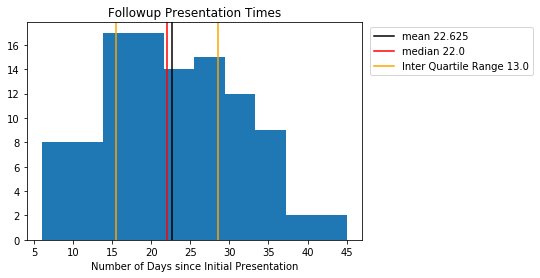

In [16]:
#Distribution of followup times

init_v_followup = df.iloc[:,8] #Days since presentation 


followup = []

#Get Followup Specimens
for i in range(len(init_v_followup)):
    if init_v_followup.iloc[i] > 5: 
        followup.append(init_v_followup.iloc[i])

mean_followup = np.mean(followup)


median_followup = np.median(followup)


iqr_followup = stats.iqr(followup)


_ = plt.figure()
_ = plt.hist(followup)
_ = plt.axvline(mean_followup, color = "Black", label = "mean {}".format(mean_followup))
_ = plt.axvline(median_followup, color = "Red", label = "median {}".format(median_followup))
_ = plt.axvline(median_followup-(0.5*iqr_followup),color = "Orange", label = "Inter Quartile Range {}".format(iqr_followup))
_ = plt.axvline(median_followup+(0.5*iqr_followup),color = "Orange")
_ = plt.legend(bbox_to_anchor=(1.01, 1))
_ = plt.title("Followup Presentation Times")
_ = plt.xlabel("Number of Days since Initial Presentation")
_ = plt.savefig("Number of Days since Initial Presentation.pdf", format = 'pdf')